In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from collections import defaultdict

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.mean()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=10, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, nesting_list, num_classes=10, use_mrl=True, single_layer_size=None):
        super(ResNet9, self).__init__()
        self.in_planes = 64
        self.use_mrl = use_mrl
        self.single_layer_size = single_layer_size
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        if not use_mrl and single_layer_size is not None:
            self.layer1 = self._make_layer(64, 2, stride=1)
            self.layer2 = self._make_layer(128, 2, stride=2)
            self.layer3 = self._make_layer(single_layer_size, 2, stride=2)
            self.linear = nn.Linear(single_layer_size, num_classes)
        else:
            self.layer1 = self._make_layer(64, 2, stride=1)
            self.layer2 = self._make_layer(128, 2, stride=2)
            self.layer3 = self._make_layer(256, 2, stride=2)
            self.linear = MRL_Linear_Layer(nesting_list, num_classes=num_classes, efficient=False)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
def prepare_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)
    
    return train_loader, val_loader, test_loader

In [5]:
def train(model, criterion, optimizer, train_loader, epoch, device, use_mrl):
    model.train()
    train_loss = 0
    correct = defaultdict(int)
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if use_mrl:
            loss = criterion(outputs, targets)
            for i, n in enumerate(model.linear.nesting_list):
                _, predicted = outputs[i].max(1)
                correct[n] += predicted.eq(targets).sum().item()
        else:
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            correct[model.single_layer_size] += predicted.eq(targets).sum().item()
            
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += targets.size(0)
    
    if use_mrl:
        avg_acc = 100. * sum(correct.values()) / (total * len(model.linear.nesting_list))
    else:
        avg_acc = 100. * sum(correct.values()) / total
        
    return train_loss/len(train_loader), avg_acc

In [6]:
def validate(model, criterion, val_loader, device, use_mrl):
    model.eval()
    val_loss = 0
    correct = defaultdict(int)
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            if use_mrl:
                loss = criterion(outputs, targets)
                for i, n in enumerate(model.linear.nesting_list):
                    _, predicted = outputs[i].max(1)
                    correct[n] += predicted.eq(targets).sum().item()
            else:
                loss = criterion(outputs, targets)
                _, predicted = outputs.max(1)
                correct[model.single_layer_size] += predicted.eq(targets).sum().item()
                
            val_loss += loss.item()
            total += targets.size(0)
    
    if use_mrl:
        avg_acc = 100. * sum(correct.values()) / (total * len(model.linear.nesting_list))
    else:
        avg_acc = 100. * sum(correct.values()) / total
        
    return val_loss/len(val_loader), avg_acc

In [7]:
def test(model, test_loader, device, use_mrl, nesting_list=None, single_layer_size=None):
    model.eval()
    test_loss = 0
    correct_top1 = defaultdict(int)
    correct_top5 = defaultdict(int)
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            if use_mrl:
                loss = criterion(outputs[0], targets)
                test_loss += loss.item()
                
                for i, n in enumerate(nesting_list):
                    _, predicted = outputs[i].max(1)
                    correct_top1[n] += predicted.eq(targets).sum().item()
                    
                    _, top5_pred = outputs[i].topk(5, 1, True, True)
                    correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            else:
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                
                _, predicted = outputs.max(1)
                correct_top1[single_layer_size] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs.topk(5, 1, True, True)
                correct_top5[single_layer_size] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    if use_mrl:
        avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
        avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
        
        print("\n┌──────────┬────────────┬────────────┐")
        print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
        print("├──────────┼────────────┼────────────┤")
        
        for n in nesting_list:
            top1 = 100. * correct_top1[n] / total
            top5 = 100. * correct_top5[n] / total
            print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
        
        print("├──────────┼────────────┼────────────┤")
        print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
        print("└──────────┴────────────┴────────────┘")
    else:
        top1 = 100. * correct_top1[single_layer_size] / total
        top5 = 100. * correct_top5[single_layer_size] / total
        
        print("\n┌──────────┬────────────┬────────────┐")
        print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
        print("├──────────┼────────────┼────────────┤")
        print(f"│ {single_layer_size:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
        print("└──────────┴────────────┴────────────┘")
        
        avg_top1 = top1
    
    return avg_top1, correct_top1

In [8]:
def plot_training_results(train_losses, train_accs, val_losses, val_accs, title_suffix=""):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
def run_experiment(use_mrl=True, single_layer_size=None, epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*50}")
    print(f"Starting experiment: {'MRL' if use_mrl else 'Single Layer'} {f'size={single_layer_size}' if not use_mrl else ''}")
    print(f"{'='*50}")
    
    train_loader, val_loader, test_loader = prepare_data()
    nesting_list = [8, 16, 32, 64, 128, 256]
    
    if use_mrl:
        model = ResNet9(nesting_list, num_classes=10, use_mrl=True)
        relative_importance = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        relative_importance_tensor = torch.tensor(relative_importance, device=device)
        criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
    else:
        model = ResNet9(nesting_list=None, num_classes=10, use_mrl=False, single_layer_size=single_layer_size)
        criterion = nn.CrossEntropyLoss()
    
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    with tqdm(range(epochs), desc='Training', file=sys.stdout, colour='green') as pbar:
        for epoch in pbar:
            train_loss, train_acc = train(model, criterion, optimizer, train_loader, epoch, device, use_mrl)
            val_loss, val_acc = validate(model, criterion, val_loader, device, use_mrl)
            scheduler.step()

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
                
            pbar.set_postfix({
                'Train Loss': f'{train_loss:.3f}',
                'Val Acc': f'{val_acc:.2f}%',
                'LR': f'{optimizer.param_groups[0]["lr"]:.5f}'
            })

    plot_training_results(train_losses, train_accs, val_losses, val_accs, 
                         f"({'MRL' if use_mrl else f'Single Layer {single_layer_size}'})")
    
    print("\nTest Results:")
    if use_mrl:
        avg_top1, correct_top1 = test(model, test_loader, device, use_mrl, nesting_list)
    else:
        avg_top1, correct_top1 = test(model, test_loader, device, use_mrl, single_layer_size=single_layer_size)
    
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images[:4]))
    print('GroundTruth:', ' '.join(f'{labels[j]}' for j in range(4)))

    print("\nPredictions:")
    outputs = model(images[:4].to(device))
    if use_mrl:
        for i, n in enumerate(nesting_list):
            _, predicted = torch.max(outputs[i], 1)
            print(f"Size {n}: {' '.join(f'{predicted[j].item()}' for j in range(4))}")
    else:
        _, predicted = torch.max(outputs, 1)
        print(f"Size {single_layer_size}: {' '.join(f'{predicted[j].item()}' for j in range(4))}")
    
    return correct_top1

In [11]:
def main():
    all_results = {}
    
    # 1. First run MRL experiment
    mrl_results = run_experiment(use_mrl=True)
    all_results['MRL'] = mrl_results
    
    # 2. Then run single layer experiments for each size
    layer_sizes = [256, 128, 64, 32, 16, 8]
    for size in layer_sizes:
        single_layer_results = run_experiment(use_mrl=False, single_layer_size=size)
        all_results[f'Single_{size}'] = single_layer_results
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    
    # MRL results
    mrl_sizes = sorted([k for k in all_results['MRL'].keys()])
    mrl_accs = [all_results['MRL'][size]/100 for size in mrl_sizes]
    plt.plot(mrl_sizes, mrl_accs, 'o-', label='MRL', linewidth=2)
    
    # Single layer results
    single_sizes = sorted([int(k.split('_')[1]) for k in all_results if k.startswith('Single_')])
    single_accs = [all_results[f'Single_{size}'][size]/100 for size in single_sizes]
    plt.plot(single_sizes, single_accs, 's-', label='Single Layer', linewidth=2)
    
    plt.title('Comparison of MRL vs Single Layer Approaches')
    plt.xlabel('Layer Size')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.xticks([8, 16, 32, 64, 128, 256])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Starting experiment: MRL 
Files already downloaded and verified
Files already downloaded and verified
Training: 100%|█| 10/10 [03:05<00:00, 18.59s/it, Train Loss=0.291, Val Acc=87.89


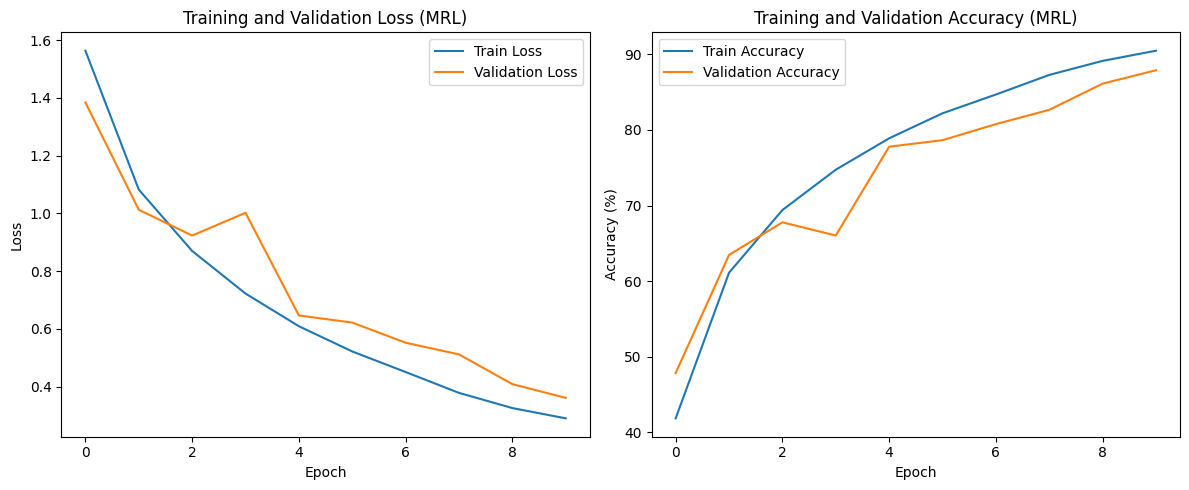


Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     86.86% │     99.61% │
│    16    │     87.61% │     99.59% │
│    32    │     87.67% │     99.63% │
│    64    │     87.57% │     99.64% │
│   128    │     87.70% │     99.67% │
│   256    │     87.69% │     99.65% │
├──────────┼────────────┼────────────┤
│ Average  │     87.52% │     99.63% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


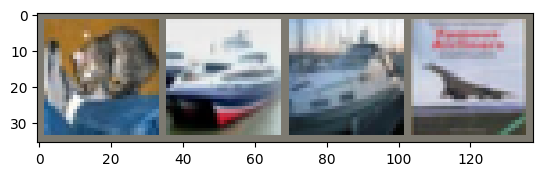

GroundTruth: 3 8 8 0

Predictions:
Size 8: 3 8 8 0
Size 16: 3 8 8 0
Size 32: 3 8 8 0
Size 64: 3 8 8 0
Size 128: 3 8 8 0
Size 256: 3 8 8 0

Starting experiment: Single Layer size=256
Files already downloaded and verified
Files already downloaded and verified
Training: 100%|█| 10/10 [03:01<00:00, 18.11s/it, Train Loss=0.272, Val Acc=88.10


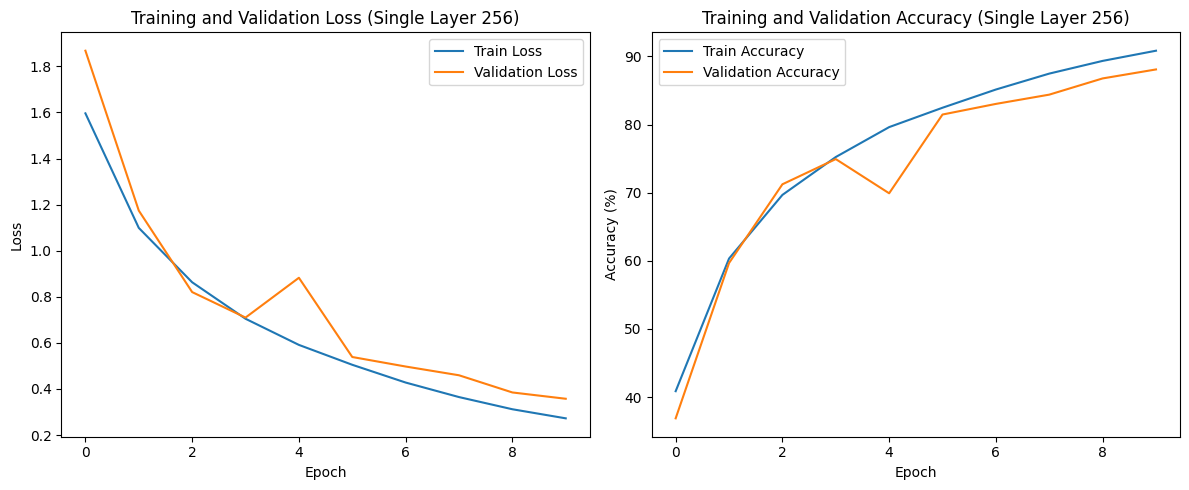


Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   256    │     87.95% │     99.60% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


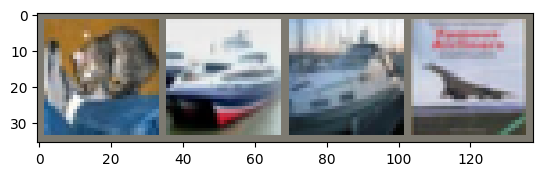

GroundTruth: 3 8 8 0

Predictions:
Size 256: 3 8 8 0

Starting experiment: Single Layer size=128
Files already downloaded and verified
Files already downloaded and verified
Training: 100%|█| 10/10 [02:57<00:00, 17.77s/it, Train Loss=0.278, Val Acc=87.58


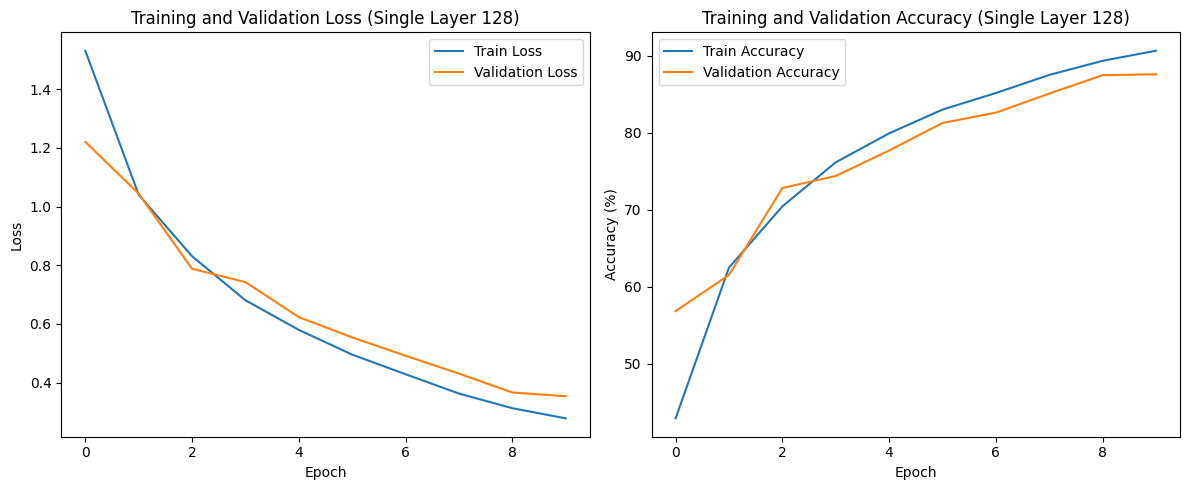


Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     87.65% │     99.56% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


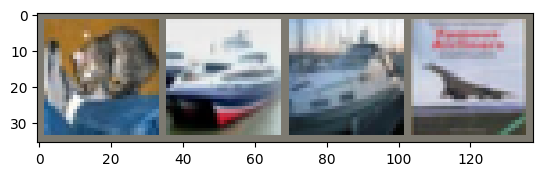

GroundTruth: 3 8 8 0

Predictions:
Size 128: 3 8 8 0

Starting experiment: Single Layer size=64
Files already downloaded and verified
Files already downloaded and verified
Training: 100%|█| 10/10 [02:57<00:00, 17.72s/it, Train Loss=0.311, Val Acc=87.46


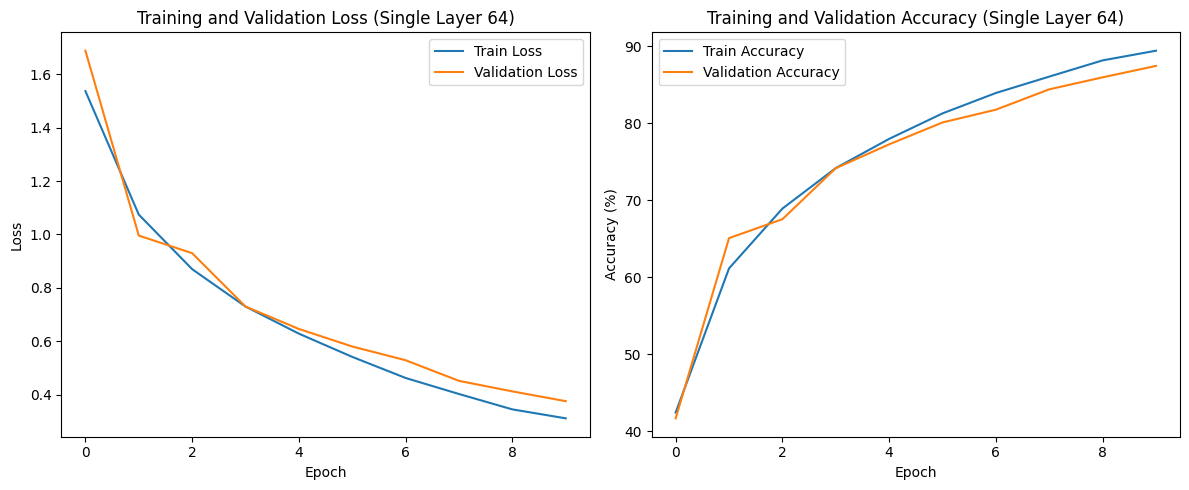


Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     86.86% │     99.47% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


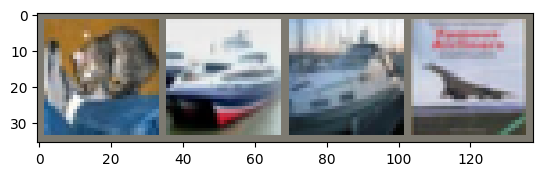

GroundTruth: 3 8 8 0

Predictions:
Size 64: 3 8 8 0

Starting experiment: Single Layer size=32
Files already downloaded and verified
Files already downloaded and verified
Training: 100%|█| 10/10 [02:57<00:00, 17.71s/it, Train Loss=0.329, Val Acc=86.54


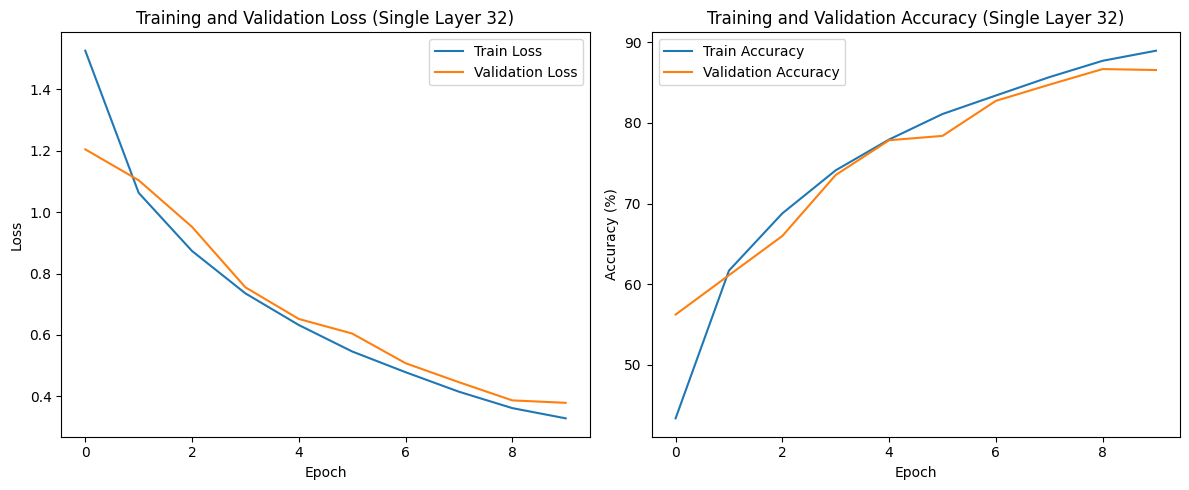


Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    32    │     86.17% │     99.34% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


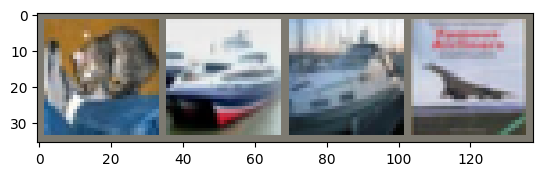

GroundTruth: 3 8 8 0

Predictions:
Size 32: 3 8 8 8

Starting experiment: Single Layer size=16
Files already downloaded and verified
Files already downloaded and verified
Training: 100%|█| 10/10 [02:56<00:00, 17.64s/it, Train Loss=0.357, Val Acc=85.88


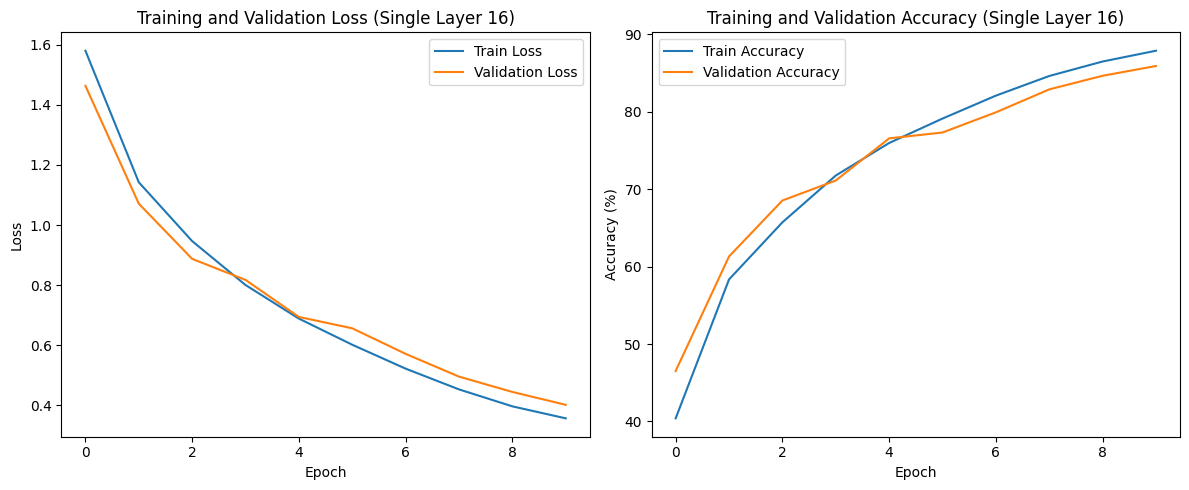


Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    16    │     85.12% │     99.39% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


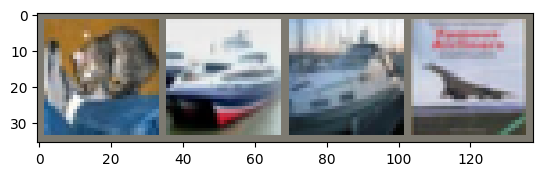

GroundTruth: 3 8 8 0

Predictions:
Size 16: 3 8 8 0

Starting experiment: Single Layer size=8
Files already downloaded and verified
Files already downloaded and verified
Training: 100%|█| 10/10 [02:56<00:00, 17.64s/it, Train Loss=0.397, Val Acc=83.82


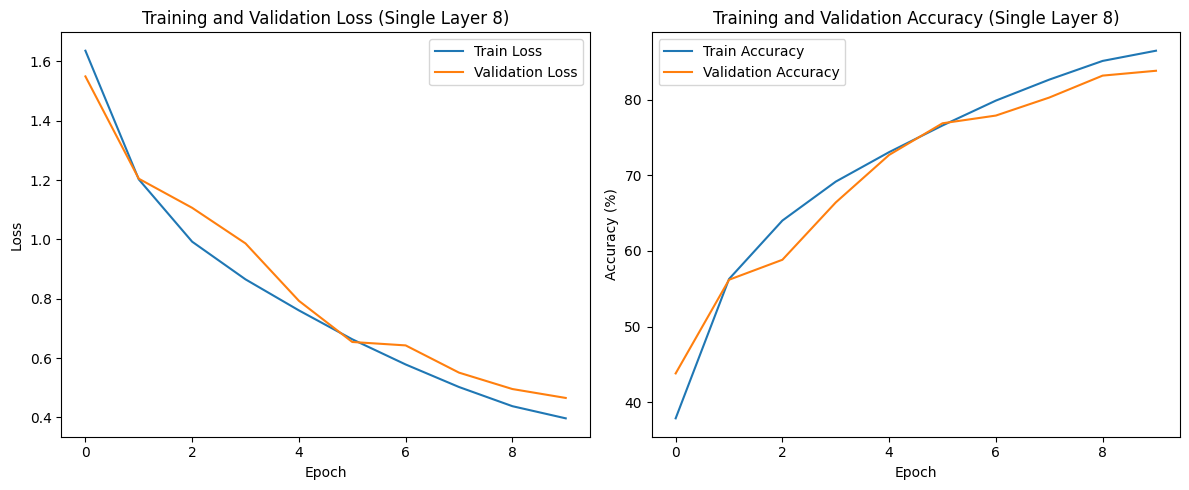


Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     83.76% │     99.35% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


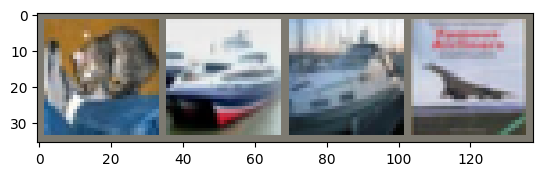

GroundTruth: 3 8 8 0

Predictions:
Size 8: 3 8 8 8


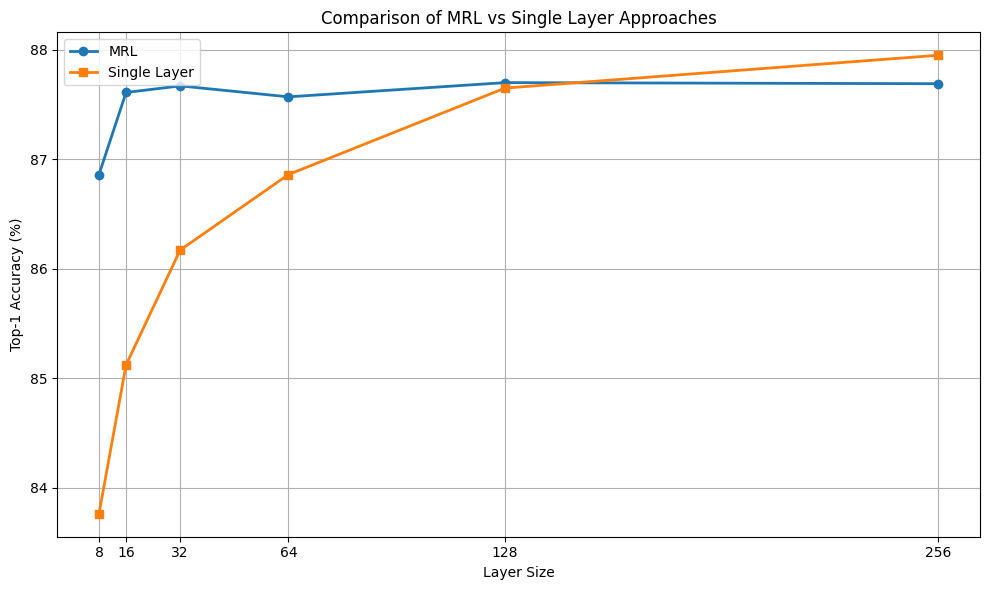

In [12]:
if __name__ == "__main__":
    main()